<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/GNN_for_Anti_Money_Laundering_in_Bitcoin_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio torch-geometric
!pip install --upgrade scipy networkx



import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch
from tabulate import tabulate
from google.colab import files
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
from torch.optim import Adam

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE









In [ ]:
!unzip elliptic
%cd ./elliptic_bitcoin_dataset

Archive:  elliptic.zip
replace elliptic_bitcoin_dataset/elliptic_txs_classes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/elliptic_bitcoin_dataset


# Dataset

As reported in [Kaggle](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) "*The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

If you make use of the Elliptic Data Set in your research, please consider citing*"

Dataset Content

* Node: represents a transaction.
  - Each has 166 features
  - Labeled as ✅ licit, ❌ illicit or 🤷 unknown

* Edge: represents a flow of Bitcoins between transaction A and transaction B


Before we start, here are a couple concepts you should know for better understanding of the following code:



$$
\begin{array}{|l|l|p{5cm}|l|}
\hline
\textbf{Concept} & \textbf{Math Notation} & \textbf{Description} & \textbf{More Information} \\
\hline
\text{Graph} & G & \text{Defined as pair } G = (V, E), \text{ where } V \text{ is a set of vertices and } E \text{ is a set of edges} & \text{Wikipedia: Graph (discrete mathematics)} \\
& & \text{which are unordered pairs } v_1, v_2 \text{ of vertices.} & \\
\hline
\text{Degree} & deg & \text{Number of edges that are incident to a vertex.} & \text{Wikipedia: Degree (graph theory)} \\
\hline
\text{Component} & & \text{Connected subgraph that is not part of any larger connected subgraph.} & \text{Wikipedia: Component (graph theory)} \\
\hline
\end{array}
$$

🚨 In the following notebook we will always call the graph G, the set of nodes V and the set of edges E. 🚨

# Overview

Let's start by getting an overview of the datasets.



In [ ]:
elliptic_txs_features = pd.read_csv('./elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('./elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('./elliptic_txs_edgelist.csv')



In [ ]:
elliptic_txs_features

0    1         2         3         4          5         6    \
0       230425980    1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1         5530458    1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2       232022460    1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3       232438397    1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4       230460314    1  1.011523 -0.081127 -1.201369   1.153668  0.333276   
...           ...  ...       ...       ...       ...        ...       ...   
203764  173077460   49 -0.145771 -0.163752  0.463609  -0.121970 -0.043875   
203765  158577750   49 -0.165920 -0.123607  1.018602  -0.121970 -0.043875   
203766  158375402   49 -0.172014 -0.078182  1.018602   0.028105 -0.043875   
203767  158654197   49 -0.172842 -0.176622  1.018602  -0.121970 -0.043875   
203768  157597225   49 -0.012037 -0.132276  0.463609  -0.121970 -0.043875   

             7          8         9    ...       157       158       159  \
0      -0.113002  -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330   
1      -0.113002  -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074   
2      -0.113002  -0.061584 -0.162749  ...  0.670883  0.439728 -0.979074   
3       9.782742  12.414558 -0.163645  ... -0.577099 -0.613614  0.241128   
4       1.312656  -0.061584 -0.163523  ... -0.511871 -0.400422  0.517257   
...          ...        ...       ...  ...       ...       ...       ...   
203764 -0.113002  -0.061584 -0.135803  ... -0.577099 -0.613614  0.241128   
203765 -0.113002  -0.061584 -0.156418  ...  0.162722  0.010822  1.461330   
203766  0.054722  -0.061584 -0.163626  ...  1.261246  1.985050  1.461330   
203767 -0.113002  -0.061584 -0.163501  ... -0.397749 -0.411776  1.461330   
203768 -0.113002  -0.061584  0.001027  ... -0.577099 -0.613614  0.241128   

             160       161       162       163       164       165       166  
0       1.461369  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
1      -0.978556  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
2      -0.978556 -0.098889 -0.106715 -0.131155 -0.183671 -0.120613 -0.119792  
3       0.241406  1.072793  0.085530 -0.131155  0.677799 -0.120613 -0.119792  
4       0.579382  0.018279  0.277775  0.326394  1.293750  0.178136  0.179117  
...          ...       ...       ...       ...       ...       ...       ...  
203764  0.241406  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
203765  1.461369 -0.098889 -0.087490 -0.084674 -0.140597 -1.760926 -1.760984  
203766  1.461369  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
203767  1.461369 -0.098889 -0.087490 -0.084674 -0.140597  1.519700  1.521399  
203768  0.241406 -0.098889 -0.087490 -0.084674 -0.140597  1.519700  1.521399  

[203769 rows x 167 columns]

In [ ]:
print(f"{elliptic_txs_features.shape[0]:8,}")

 203,769


In [ ]:
# Rename the elliptic_txs_features columns
elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



Let's get an overview on the distribution of the classes.



In [ ]:
elliptic_txs_classes["class"].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

In [ ]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True)

class_mapped
unknown    77.148634
licit      20.620899
illicit     2.230467
Name: proportion, dtype: float64

See labels

In [ ]:

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()


classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
})
classes_df

Class Mapped Class Raw  Counts  Percentage
0      unknown   unknown  157205       77.15
1        licit         2   42019       20.62
2      illicit         1    4545        2.23

In [ ]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')


In [ ]:
# Take a subgraph for connectivity metrics computations


num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")
sub = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(sub)



print(f"Giant component - Number of nodes: {G_sub.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_sub.number_of_edges():,}")


Number of connected components: 49
Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


# Utilis Functions

In [ ]:
def get_color_map(top , metric ):
  """
    Multiplies two numbers and returns the result.

    Args:
        top (pd.Series): list of top node metric.
        metric (dict): connectivity metric.

    Returns:
        G: subgraph containig the top nodes.
        norm: The normalized color map used as input to the colorbar.
        node_color_norm: The normalized color map for the nodes colors.
    """

  top_nodes = top.tolist()
  # create the subgraph
  G_subgraph = G.subgraph(top_nodes)
  # create the color map
  node_color = [metric[node] for node in top_nodes]
  norm = mpt.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
  node_color_norm = [norm(value) for value in node_color]


  return G_subgraph,norm, node_color_norm


In [ ]:
import random

def set_seed(seed):
    """
    Fix the random seed for reproducibility.

    Parameters:
    seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (for single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (for all GPUs)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

# 🔍 Exploratory Data Analysis (EDA)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops = {'edgecolor' : 'black',
                      'linewidth': 2,
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

NameError: name 'num_nodes' is not defined

<Figure size 400x400 with 0 Axes>

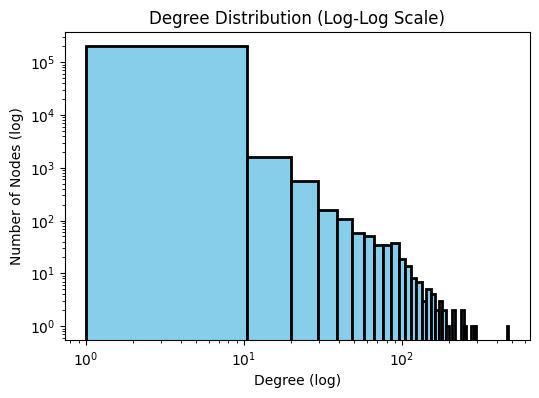

In [ ]:
# --- Degree Distribution (Log-Log Scale) ---
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

# Graph connectivity

Shortest paths length distribution in the giant component


In [ ]:
paths = dict(nx.shortest_path_length(G_sub))
# If neither the source nor target are specified, return an iterator over (source, dictionary)
# where dictionary is keyed by target to shortest path length from source to that target.
paths_val = [l for val in paths.values() for l in val.values()]
plt.figure(figsize=(6, 4))
plt.hist(paths_val, bins = 50, edgecolor = "black")
plt.title("Shortest Path Length Distribution")
plt.xlabel("Shortest Path Length")
plt.ylabel("Number of Nodes")
plt.show()



Degree Centrality

In [ ]:
degree_centrality = nx.degree_centrality(G_sub)
top_ten_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10] # sort by degree
dp_top_ten_degree_centrality = pd.DataFrame(top_ten_degree_centrality, columns=['node', 'degree_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(dp_top_ten_degree_centrality["node"],degree_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(dp_top_ten_degree_centrality)

Top 10 node centrality
##########
        node  degree_centrality
0      89273           0.036680
1  232438397           0.020434
2    2881273           0.018150
3  230658142           0.017007
4    2758467           0.013453
5    2881274           0.012311
6  232029206           0.007615
7   43560505           0.006346
8    2880930           0.006219
9   27405707           0.005077


<ipython-input-22-213f3490c8cc>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')


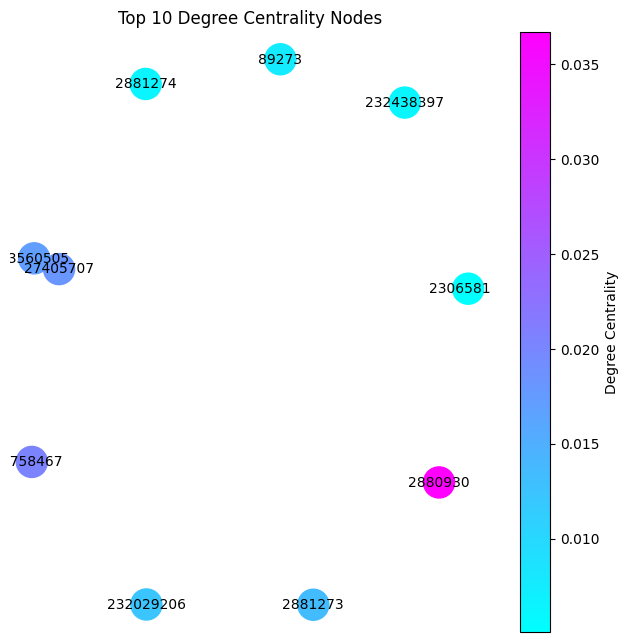

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')
plt.show()

Betweeness centrality

In [ ]:
betweenness_centrality= nx.betweenness_centrality(G_sub)

TypeError: sorted expected 1 argument, got 2

In [ ]:
top_betweenness_centrality = sorted(betweenness_centrality.items(), key= lambda x:x[1], reverse = True )[:10]
pd_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns = ['node', 'betweenness_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(pd_top_betweenness_centrality["node"],betweenness_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(pd_top_betweenness_centrality)

Top 10 node centrality
##########
        node  betweenness_centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


<ipython-input-32-cf3d4502fbdb>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')


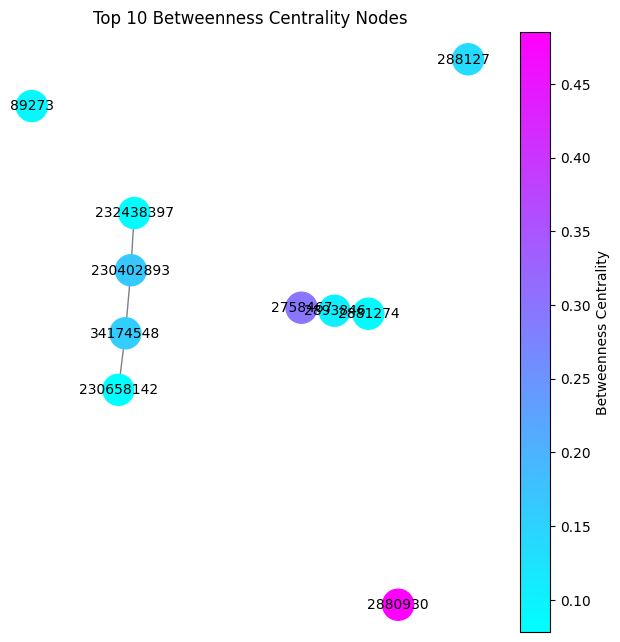

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True, edge_color = "grey", node_size = 500, font_size = 10, node_color=node_color_norm, cmap=mpt.cm.cool)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')
plt.show()

Closeness centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(G_sub)
top_ten_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
pd_top_closeness_centrality = pd.DataFrame(top_ten_closeness_centrality, columns=['node', 'closeness_centrality'])

# print
print("top 10 Closeness Centrality")
print("##########")
print(pd_top_closeness_centrality)


top 10 Closeness Centrality
##########
        node  closeness_centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


<ipython-input-35-67a4616262c9>:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')


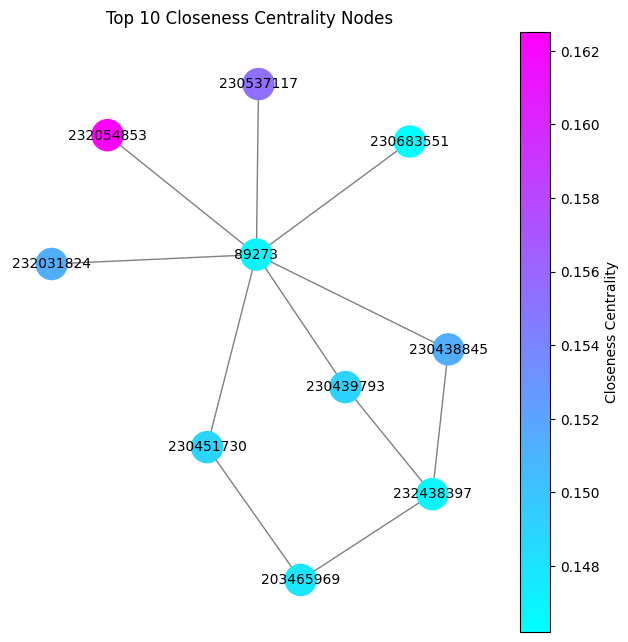

In [ ]:
G_subgraph, norm, node_color_norm= get_color_map(pd_top_closeness_centrality["node"],closeness_centrality )
# Plot
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')
plt.show()

# Graph visualization

In [ ]:
# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_ten_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_ten_closeness_centrality])

top_nodes_degree_betweenness = top_nodes_degree & top_nodes_betweenness
top_nodes_closeness_and_degree = top_nodes_closeness & top_nodes_degree
top_nodes_closeness_and_betweenness = top_nodes_closeness & top_nodes_betweenness
top_nodes_all_three = top_nodes_closeness & top_nodes_degree & top_nodes_betweenness

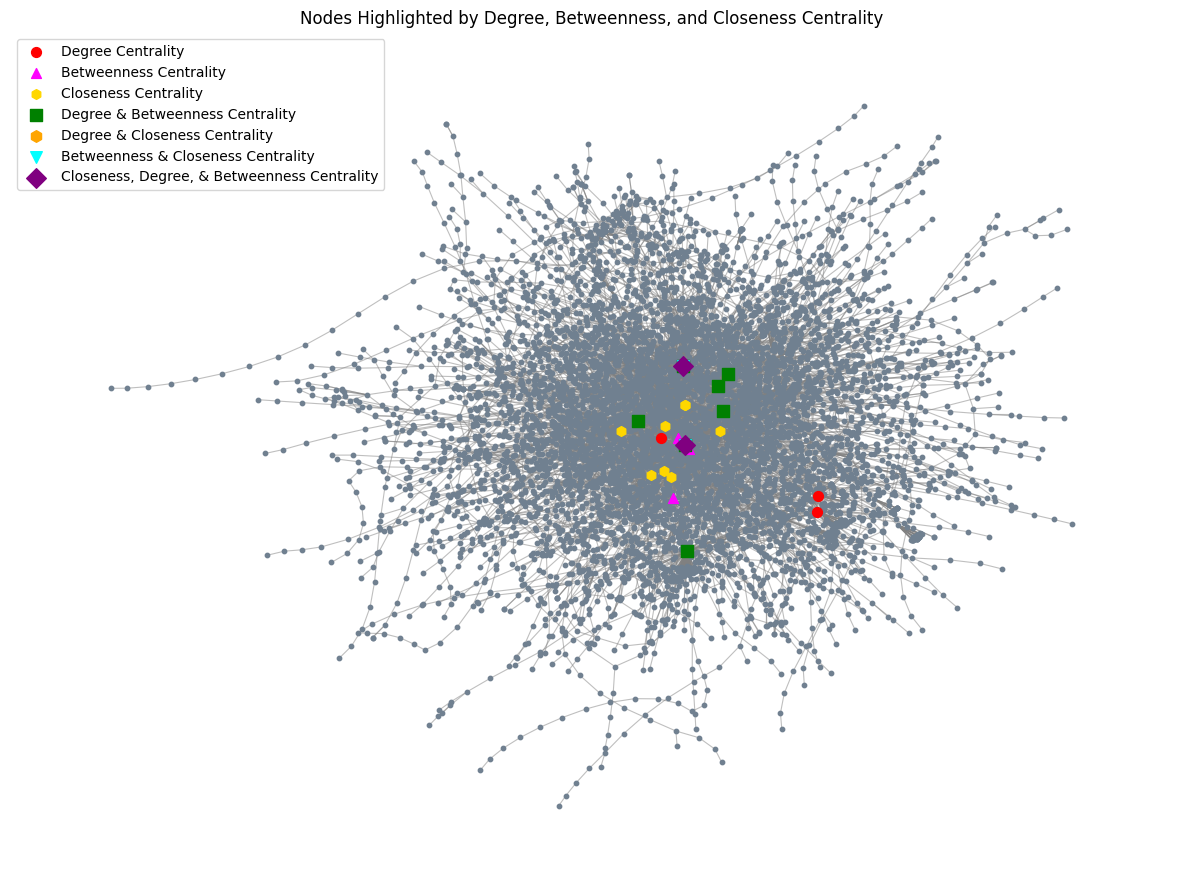

In [ ]:
plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_sub)
# Draw all nodes first.
nx.draw_networkx_nodes(G_sub,pos,  node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree - top_nodes_degree_betweenness - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o', label='Degree Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_betweenness - top_nodes_degree_betweenness - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^', label='Betweenness Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h', label='Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree_betweenness), node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')

nx.draw_networkx_nodes(G_sub, pos, nodelist=list(top_nodes_closeness_and_degree), node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness_and_betweenness), node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_all_three), node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_sub,pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

# Create the Data Object for Pytorch Geometric


Set the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
tx_id_mapping = {key: idx  for idx, key in enumerate(elliptic_txs_features['txId'])}

elliptic_txs_edgelist['Id1'] = elliptic_txs_edgelist['txId1'].map(tx_id_mapping)
elliptic_txs_edgelist['Id2'] = elliptic_txs_edgelist['txId2'].map(tx_id_mapping)


edge_index = torch.tensor(elliptic_txs_edgelist[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [ ]:
nodes_features = torch.tensor(elliptic_txs_features.drop('txId', axis=1).values, dtype=torch.float)
nodes_features.shape

torch.Size([203769, 166])

In [ ]:
mapped_labels = elliptic_txs_classes["class"].replace({"unknown":"0"})
mapped_labels = mapped_labels.astype(int)
mapped_labels.value_counts()

class
0    157205
2     42019
1      4545
Name: count, dtype: int64

In [ ]:
labels = torch.tensor(mapped_labels.values, dtype=torch.long)
labels

tensor([0, 0, 0,  ..., 1, 0, 0])

In [ ]:
# Create a pythorch geometric data object
from torch_geometric.data import Data

data = Data(x=nodes_features,
            edge_index=edge_index,
            y=labels)


In [ ]:
data.edge_index.T

tensor([[     0,      1],
        [     2,      3],
        [     4,      5],
        ...,
        [201921, 202042],
        [201480, 201368],
        [201954, 201756]])

# Train, Validation, Test masks


In [ ]:
# This is the problem
def load_split_dataset(data , train_ratio=0.6, val_ratio=0.2):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)

    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]


    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True
    data.test_mask[test_indices] = True

    # Check that the splits have no overlap
    assert torch.sum(data.train_mask & data.val_mask) == 0, "Train and validation masks overlap!"
    assert torch.sum(data.train_mask & data.test_mask) == 0, "Train and test masks overlap!"
    assert torch.sum(data.val_mask & data.test_mask) == 0, "Validation and test masks overlap!"

    print(f"Train: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}")
    return data

In [ ]:
data = load_split_dataset(data)

data = data.to(device)

Train: 122261, Val: 40753, Test: 40755


## Statistics

In [ ]:
cond1 = (data.y == 1)
cond2 = (data.y == 2)

tot_illicit = cond1.sum().item()
tot_licit = cond2.sum().item()
tot = tot_illicit+ tot_licit


In [ ]:
train_illicit = (data.y[data.train_mask == True] == 1).sum().item()
train_licit = (data.y[data.train_mask == True] == 2).sum().item()
train_unkwon = (data.y[data.train_mask == True] == 0).sum().item()

val_illicit = (data.y[data.val_mask == True] == 1).sum().item()
val_licit = (data.y[data.val_mask == True] == 2).sum().item()
val_unkwon = (data.y[data.val_mask == True] == 0).sum().item()


test_illicit = (data.y[data.test_mask == True] == 1).sum().item()
test_licit = (data.y[data.test_mask == True] == 2).sum().item()
test_unkwon = (data.y[data.test_mask == True] == 0).sum().item()



split_dic = {
    "#unkwon": [train_unkwon, val_unkwon, test_unkwon],
    "#licit": [train_licit, val_licit, test_licit],
    "#illicit": [train_illicit, val_illicit, test_illicit],
    "%licit": [100 * train_licit / tot_licit, 100 * val_licit / tot_licit, 100 * test_licit / tot_licit],
    "%illicit": [100 * train_illicit / tot_illicit, 100 * val_illicit / tot_illicit, 100 * test_illicit / tot_illicit],
    "licti + illicit": [train_licit + train_illicit, val_licit + val_illicit, test_licit + test_illicit],
    "%licti + illicit": [ 100*(train_licit + train_illicit)/tot, 100*(val_licit + val_illicit)/tot, 100*(test_licit + test_illicit)/tot]
}

split_df = pd.DataFrame(split_dic, index=["train", "val", "test"])
split_df


#unkwon  #licit  #illicit     %licit   %illicit  licti + illicit  \
train    94276   25247      2738  60.084724  60.242024            27985   
val      31442    8408       903  20.009995  19.867987             9311   
test     31487    8364       904  19.905281  19.889989             9268   

       %licti + illicit  
train         60.100077  
val           19.996134  
test          19.903788

The percentages respects the splitting condition we have set.
Maybe a more balancing could be better

# Utilis

In [ ]:
!pip install tqdm
from tqdm import tqdm


# calculate the weights based on the class distribution

def train(epoch,
          data,
          model,
          lr,
          wd):
  data = data.to(device)

  # computes the weights
  weights = data.y.unique(return_counts=True)[1].cpu().numpy()
  weights = 1/weights
  weights = weights/weights.sum()
  class_weights = torch.tensor(weights, dtype = torch.float).to(device)

  # set the paramenters
  lr = lr
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4
  criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

  # initialize lists
  loss_history = []

  for i in tqdm(range(0, epoch)):
    # set training mode
    model.train()
    # reset gradients
    opt.zero_grad()
    # get probabilities
    out = model(data)
    # compute the loss
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # compute gradients
    loss.backward()
    # optimize
    opt.step()

    # Append predictions and labels

    if i % 100 == 0:
        print(f"The current loss is {loss:.4f}")
        loss_history.append(loss.item())  # Store loss for this epoch



  return loss_history


In [ ]:
def test(data, model):
  model.eval()
  with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  print(f"Test Accuracy: {test_acc:.4f}")
  y_test = pred[data.test_mask].cpu().numpy()

  return test_acc, y_test

In [ ]:
def plot_acc(data, labels):
  # Generate the confusion matrix
  cm = confusion_matrix(data.y[data.test_mask].cpu(), labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["unkwon", 'illicit', 'licit'])

  # Plot the confusion matrix
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()


In [ ]:
def plot_loss(loss_history, epochs, model):
  fig , ax = plt.subplots()
  x = range(0, epochs +1, 100)
  ax.plot(x,loss_history, label='train_loss')
  ax.legend()
  ax.set_title(f"{model}: Train loss")
  ax.set_ylabel("CrossEntropy per epoch")
  ax.set_xlabel("Epoch")
  plt.show()

In [ ]:
from scipy.stats import wasserstein_distance
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Visualize
    plt.figure(figsize=(8, 8))
    for i in range(len(set(labels))):
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {i}', alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

    # Wasserstein distance calculation between classes
    unique_classes = np.unique(labels)
    wasserstein_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    for i in range(len(unique_classes)):
        for j in range(i+1, len(unique_classes)):
            class_i_embeddings = embeddings_2d[labels == unique_classes[i]]
            class_j_embeddings = embeddings_2d[labels == unique_classes[j]]

            # Calculate Wasserstein distance for x and y dimensions separately
            x_distance = wasserstein_distance(class_i_embeddings[:, 0], class_j_embeddings[:, 0])
            y_distance = wasserstein_distance(class_i_embeddings[:, 1], class_j_embeddings[:, 1])

            wasserstein_matrix[i, j] = np.mean([x_distance, y_distance])
            wasserstein_matrix[j, i] = wasserstein_matrix[i, j]

    return wasserstein_matrix

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def evaluate_embeddings(embeddings, labels):
    metrics = {}

    # Silhouette Score (higher is better, range [-1, 1])
    metrics['silhouette'] = silhouette_score(embeddings, labels)


    # K-NN classification accuracy (higher is better)
    knn = KNeighborsClassifier(n_neighbors=5)
    metrics['knn_accuracy'] = cross_val_score(knn, embeddings, labels, cv=5).mean()

    return metrics



# Model_1

In [ ]:
import torch_geometric.transforms as T

# There is a problem with this
transform = T.Compose([T.NormalizeFeatures()])
data = transform(data)
print(data.is_directed())
data.x[:-1]

True


tensor([[0.0066, 0.0060, 0.0060,  ..., 0.0060, 0.0060, 0.0060],
        [0.0066, 0.0060, 0.0060,  ..., 0.0061, 0.0061, 0.0061],
        [0.0066, 0.0061, 0.0061,  ..., 0.0061, 0.0061, 0.0061],
        ...,
        [0.0274, 0.0057, 0.0057,  ..., 0.0057, 0.0050, 0.0050],
        [0.0276, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        [0.0278, 0.0058, 0.0058,  ..., 0.0058, 0.0066, 0.0066]],
       device='cuda:0')

Use a GCN Layer

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class MyMPL(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN(torch.nn.Module):
    def __init__(self, input_dim , hidden_channels, self_loops= False):
        super(MyGCN, self).__init__()

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.mlp = MyMPL(hidden_channels, hidden_channels, 3)

    def forward(self, data, before = False):
        x, edge_index= data.x, data.edge_index
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x



# what are the hidden_channels?

model_1 = MyGCN(data.num_features, hidden_channels=64).to(device)
print(model_1)

MyGCN(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (mlp): MyMPL(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


## Train

In [ ]:
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=data,
      model = model_1,
      lr = .01,
      wd = 5e-4)

  0%|          | 5/1001 [00:00<01:42,  9.72it/s]

The current loss is 1.1060


 11%|█         | 108/1001 [00:03<00:20, 42.90it/s]

The current loss is 0.8529


 21%|██        | 208/1001 [00:05<00:18, 42.85it/s]

The current loss is 0.8237


 31%|███       | 308/1001 [00:07<00:16, 42.70it/s]

The current loss is 0.8076


 41%|████      | 406/1001 [00:10<00:16, 36.74it/s]

The current loss is 0.8067


 51%|█████     | 506/1001 [00:12<00:12, 39.55it/s]

The current loss is 0.7943


 61%|██████    | 606/1001 [00:15<00:09, 42.95it/s]

The current loss is 0.7970


 71%|███████   | 707/1001 [00:17<00:07, 38.92it/s]

The current loss is 0.7940


 81%|████████  | 809/1001 [00:20<00:04, 42.22it/s]

The current loss is 0.8111


 91%|█████████ | 909/1001 [00:22<00:02, 42.50it/s]

The current loss is 0.7822


100%|██████████| 1001/1001 [00:24<00:00, 40.56it/s]

The current loss is 0.7826


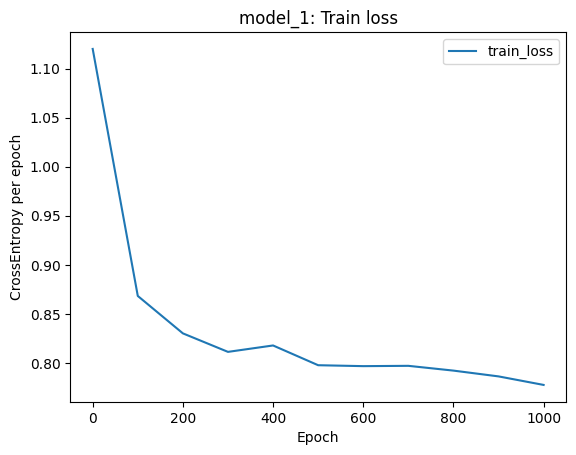

In [ ]:
plot_loss(loss_history=loss,
              epochs= 1000,
              model =  "model_1")


## Test

In [ ]:
test_acc, y_test= test(data = data, model = model_1)

Test Accuracy: 0.3881


Model_ 1 accieved accuracy of: 0.38809961967856704


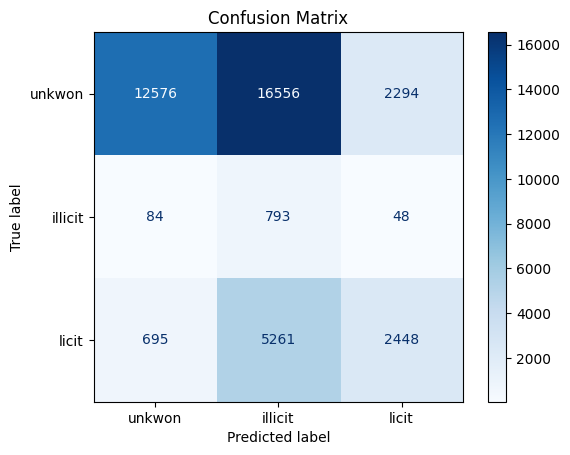

In [ ]:
print(f"Model_ 1 accieved accuracy of: {test_acc}")
plot_acc(data, y_test)

The model is entirely biased towards predicting the unknown class for all inputs, regardless of the actual class.

## Visualiza Embeddings

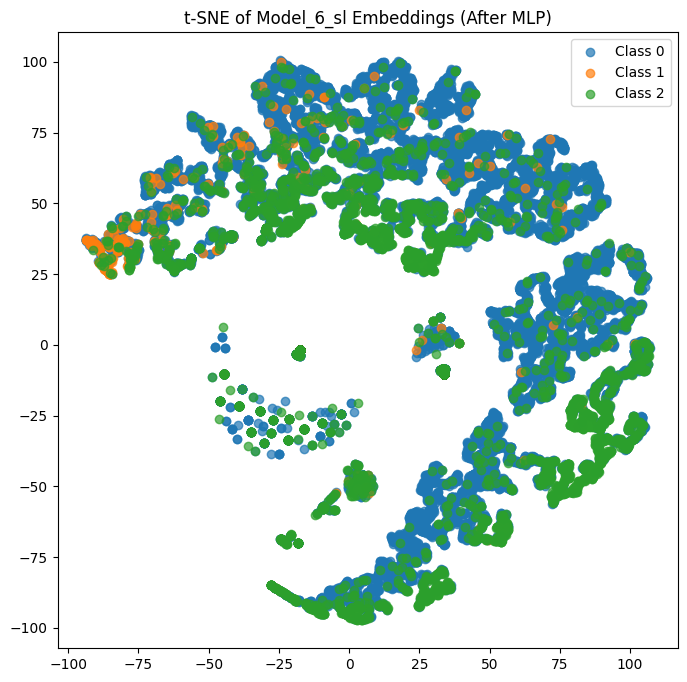

wasserstein distance Matrix:
[[0.         1.         0.57235375]
 [1.         0.         0.93959252]
 [0.57235375 0.93959252 0.        ]]


In [ ]:
model_1.eval()

with torch.no_grad():
  test_embeddings_1 = model_1.forward(data)[data.test_mask].cpu().numpy()

WS_GNN1 = plot_tsne(test_embeddings_1, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN1/np.max(WS_GNN1)}")

In [ ]:
WS_mean_GNN1 = WS_GNN1.mean()

In [ ]:
metrics_1 = evaluate_embeddings(test_embeddings_1, data.y[data.test_mask].cpu().numpy())
metrics_1

{'silhouette': -0.34639558, 'knn_accuracy': 0.6237271500429395}

 # Model 2


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

class MyMPL2(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL2, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN2(torch.nn.Module):
    def __init__(self,input_dim, hidden_channels, self_loops = False):
        super(MyGCN2, self).__init__()
        self.add_self_loops = self_loops

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops= self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops= self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer

        self.mlp = MyMPL2(hidden_channels, hidden_channels, 3)

    def forward(self, data, before = False):
        x, edge_index = data.x, data.edge_index
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x





In [ ]:
model_2 = MyGCN2(input_dim = data.num_features, hidden_channels=64).to(device)
print(model_2)

MyGCN2(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


## Train

In [ ]:
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=data,
      model = model_2,
      lr = .01,
      wd = 5e-4)

  0%|          | 5/1001 [00:00<00:43, 23.05it/s]

The current loss is 1.1146


 10%|█         | 105/1001 [00:03<00:26, 34.00it/s]

The current loss is 0.9104


 20%|██        | 205/1001 [00:06<00:23, 33.72it/s]

The current loss is 0.8978


 30%|███       | 305/1001 [00:09<00:20, 33.69it/s]

The current loss is 0.8913


 40%|████      | 405/1001 [00:12<00:17, 34.08it/s]

The current loss is 0.8926


 50%|█████     | 505/1001 [00:14<00:14, 33.97it/s]

The current loss is 0.8875


 60%|██████    | 605/1001 [00:17<00:11, 33.61it/s]

The current loss is 0.8856


 70%|███████   | 705/1001 [00:20<00:08, 33.86it/s]

The current loss is 0.8896


 80%|████████  | 805/1001 [00:23<00:05, 33.54it/s]

The current loss is 0.8884


 90%|█████████ | 905/1001 [00:26<00:02, 33.88it/s]

The current loss is 0.8897


100%|██████████| 1001/1001 [00:29<00:00, 33.69it/s]

The current loss is 0.8835


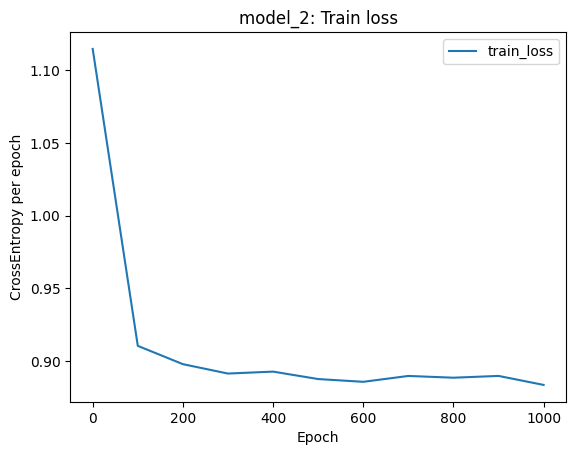

In [ ]:
plot_loss(loss_history=loss,
              epochs= 1000,
              model =  "model_2")


## Test

In [ ]:
test_acc, y_test= test(data = data, model = model_2)

Test Accuracy: 0.4607


Model_2 accieved accuracy of: 0.460679671205987


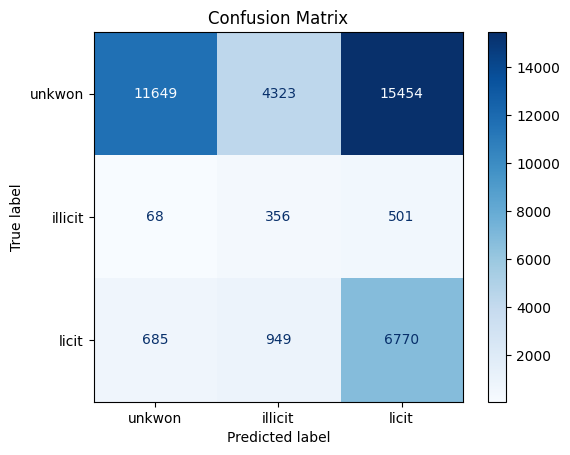

In [ ]:
print(f"Model_2 accieved accuracy of: {test_acc}")
plot_acc(data, y_test)

## Visualize Embeddings

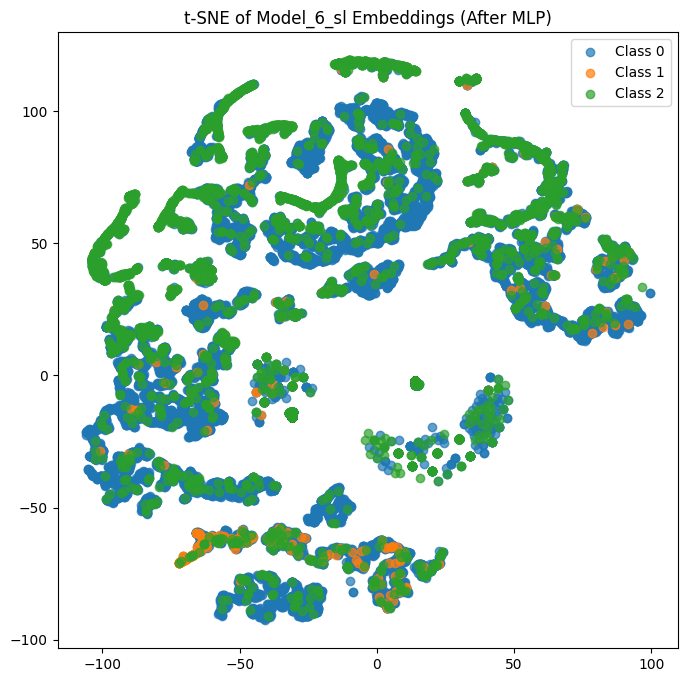

wasserstein distance Matrix:
[[0.         0.68677869 0.42732558]
 [0.68677869 0.         1.        ]
 [0.42732558 1.         0.        ]]


In [ ]:
model_2.eval()

with torch.no_grad():
  test_embeddings_2 = model_2.forward(data)[data.test_mask].cpu().numpy()

WS_GNN2 = plot_tsne(test_embeddings_2, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN2/np.max(WS_GNN2)}")

In [ ]:
WS_mean_GNN2 = WS_GNN2.mean()

In [ ]:
metrics_2 = evaluate_embeddings(test_embeddings_2, data.y[data.test_mask].cpu().numpy())
metrics_2

{'silhouette': -0.40547168, 'knn_accuracy': 0.6522144522144522}

# Adding self loops

## Train

In [ ]:
model_1_sl = MyGCN(input_dim = data.num_features, hidden_channels=64, self_loops = True).to(device)
model_2_sl = MyGCN2(input_dim = data.num_features, hidden_channels=64, self_loops = True).to(device)
print(model_1_sl)
print(model_2_sl)

MyGCN(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (mlp): MyMPL(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)
MyGCN2(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [ ]:
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=data,
      model = model_1_sl,
      lr = .01,
      wd = 5e-4)

  1%|          | 6/1001 [00:00<00:38, 25.65it/s]

The current loss is 1.1732


 10%|█         | 105/1001 [00:03<00:27, 32.65it/s]

The current loss is 0.4333


 20%|██        | 205/1001 [00:06<00:24, 32.67it/s]

The current loss is 0.3491


 30%|███       | 305/1001 [00:09<00:21, 32.10it/s]

The current loss is 0.3514


 40%|████      | 405/1001 [00:12<00:18, 32.00it/s]

The current loss is 0.3021


 50%|█████     | 505/1001 [00:15<00:15, 32.54it/s]

The current loss is 0.2816


 60%|██████    | 605/1001 [00:18<00:12, 32.39it/s]

The current loss is 0.3045


 70%|███████   | 705/1001 [00:21<00:09, 32.40it/s]

The current loss is 0.4077


 80%|████████  | 805/1001 [00:25<00:06, 31.65it/s]

The current loss is 0.2628


 90%|█████████ | 905/1001 [00:28<00:03, 31.80it/s]

The current loss is 0.2620


100%|██████████| 1001/1001 [00:31<00:00, 32.10it/s]

The current loss is 0.2488


In [ ]:
seed = 42
set_seed(seed)

loss2 = train(epoch=1001,
      data=data,
      model = model_2_sl,
      lr = .01,
      wd = 5e-4)

  0%|          | 4/1001 [00:00<00:33, 29.99it/s]

The current loss is 1.1377


 11%|█         | 106/1001 [00:03<00:33, 26.95it/s]

The current loss is 0.5594


 20%|██        | 205/1001 [00:07<00:29, 26.56it/s]

The current loss is 0.5153


 30%|███       | 304/1001 [00:11<00:26, 26.62it/s]

The current loss is 0.4961


 41%|████      | 406/1001 [00:15<00:22, 26.80it/s]

The current loss is 0.4941


 50%|█████     | 505/1001 [00:18<00:18, 26.81it/s]

The current loss is 0.4953


 60%|██████    | 605/1001 [00:22<00:14, 26.99it/s]

The current loss is 0.4822


 70%|███████   | 704/1001 [00:26<00:11, 26.16it/s]

The current loss is 0.4837


 81%|████████  | 806/1001 [00:30<00:07, 26.66it/s]

The current loss is 0.4803


 90%|█████████ | 905/1001 [00:33<00:03, 26.69it/s]

The current loss is 0.4861


100%|██████████| 1001/1001 [00:37<00:00, 26.72it/s]

The current loss is 0.4765


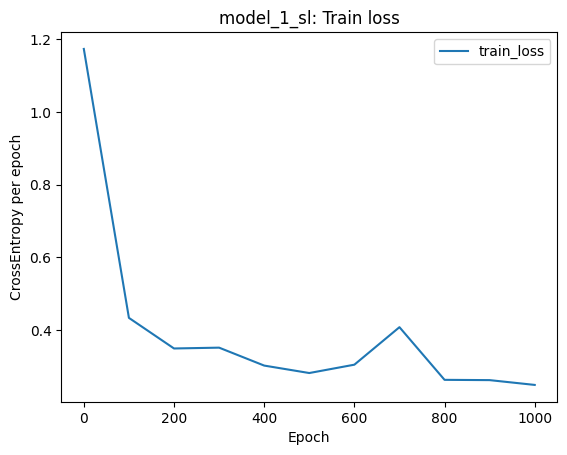

In [ ]:
plot_loss(loss_history=loss,
              epochs= 1000,
              model =  "model_1_sl")


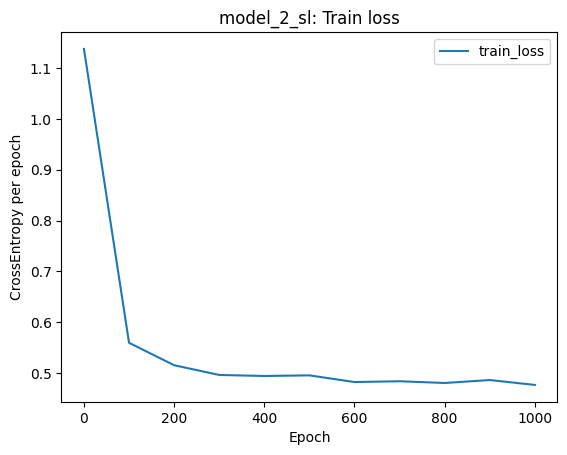

In [ ]:
plot_loss(loss_history=loss2,
              epochs= 1000,
              model =  "model_2_sl")

## Test

In [ ]:
test_acc_1, y_test_1= test(data = data, model = model_1_sl)

Test Accuracy: 0.7959


In [ ]:
test_acc_2, y_test_2= test(data = data, model = model_2_sl)

Test Accuracy: 0.7708


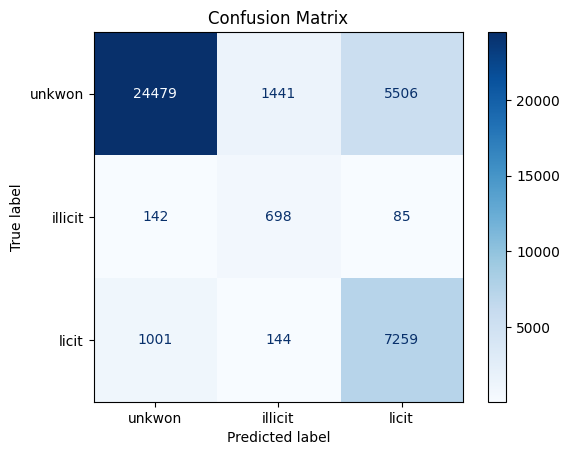

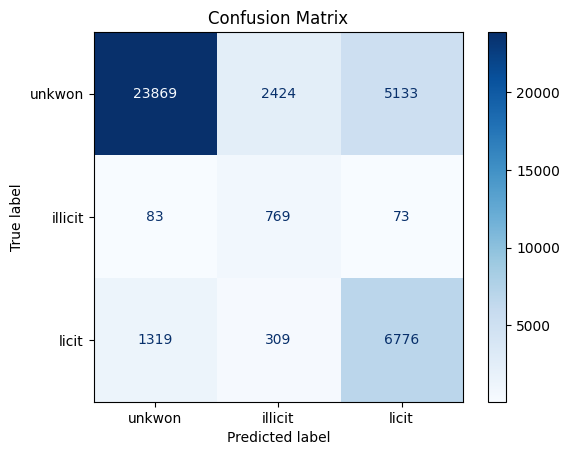

In [ ]:
plot_acc(data, y_test_1)
plot_acc(data, y_test_2)

## Visualize Embeddings

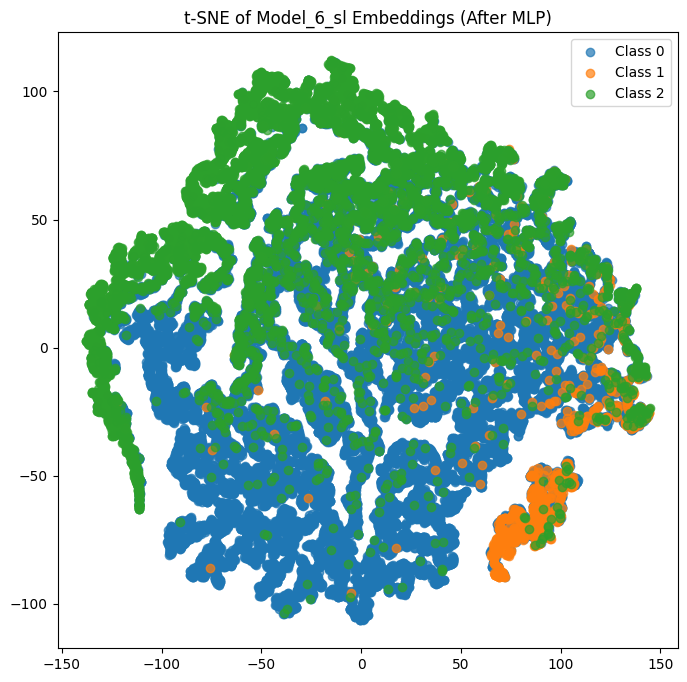

wasserstein distance Matrix:
[[0.         0.52202778 0.48054502]
 [0.52202778 0.         1.        ]
 [0.48054502 1.         0.        ]]


In [ ]:
model_1_sl.eval()

with torch.no_grad():
  test_embeddings_1_sl = model_1_sl.forward(data)[data.test_mask].cpu().numpy()

WS_GNN1_sl = plot_tsne(test_embeddings_1_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN1_sl/np.max(WS_GNN1_sl)}")

In [ ]:
WS_mean_GNN1_sl=WS_GNN1_sl.mean()

In [ ]:
metrics_1_sl = evaluate_embeddings(test_embeddings_1_sl, data.y[data.test_mask].cpu().numpy())
metrics_1_sl

{'silhouette': 0.07136947, 'knn_accuracy': 0.8558213716108453}

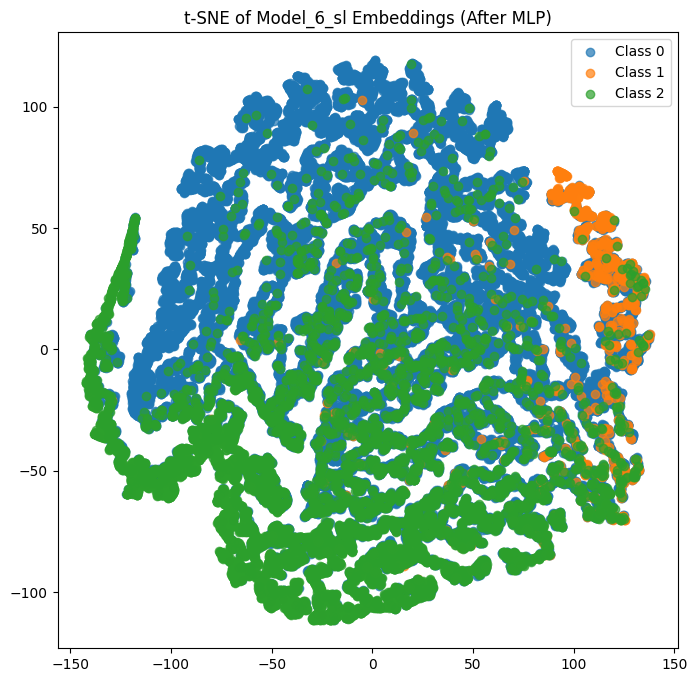

wasserstein distance Matrix:
[[0.         0.55487256 0.50794347]
 [0.55487256 0.         1.        ]
 [0.50794347 1.         0.        ]]


In [ ]:
model_2_sl.eval()

with torch.no_grad():
  test_embeddings_2_sl = model_2_sl.forward(data)[data.test_mask].cpu().numpy()

WS_GNN2_sl = plot_tsne(test_embeddings_2_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN2_sl/np.max(WS_GNN2_sl)}")

In [ ]:
WS_mean_GNN2_sl=WS_GNN2_sl.mean()

In [ ]:
metrics_2_sl = evaluate_embeddings(test_embeddings_2_sl, data.y[data.test_mask].cpu().numpy())
metrics_2_sl

{'silhouette': 0.08975185, 'knn_accuracy': 0.8370015948963317}

# Residual connections

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

class MyMPL2(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL2, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN3(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, self_loops = False, is_batch = False):
        super(MyGCN3, self).__init__()
        self.is_batch = is_batch

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.projection = torch.nn.Linear(data.num_features, hidden_channels)
        self.mlp = MyMPL2(hidden_channels, hidden_channels, 3)

    def forward(self, data, before = False):
        x, edge_index = data.x, data.edge_index
        y = self.projection(x)
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        if self.is_batch:
          x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection
        y = x

        # Second Message Passing
        x = self.conv2(x, edge_index)
        if self.is_batch:
          x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x




In [ ]:
#model_4 = MyGCN3(input_dim = data.num_features, hidden_channels=64, is_batch = False).to(device)
#model_4_sl = MyGCN3(input_dim = data.num_features, hidden_channels=64, self_loops = True).to(device)
#model_5 = MyGCN3(input_dim = data.num_features, hidden_channels=64, is_batch = True).to(device)
model_5_sl = MyGCN3(input_dim = data.num_features, hidden_channels=64, self_loops = True, is_batch = True).to(device)


#print(model_4)
#print(model_4_sl)
#print(model_5)
print(model_5_sl)

MyGCN3(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (projection): Linear(in_features=166, out_features=64, bias=True)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


## Train

In [ ]:
models = [model_4, model_4_sl, model_5, model_5_sl]
seed = 42
set_seed(seed)

losses = []

for model in models:
  loss = train(epoch=1001,
      data=data,
      model = model,
      lr = .01,
      wd = 5e-4)
  losses.append(loss)


  1%|          | 6/1001 [00:00<00:39, 25.48it/s]

The current loss is 1.2274


 10%|█         | 105/1001 [00:03<00:28, 32.00it/s]

The current loss is 0.3684


 20%|██        | 205/1001 [00:06<00:24, 32.09it/s]

The current loss is 0.2986


 30%|███       | 305/1001 [00:09<00:21, 32.22it/s]

The current loss is 0.2755


 40%|████      | 405/1001 [00:12<00:18, 32.18it/s]

The current loss is 0.2554


 50%|█████     | 505/1001 [00:15<00:15, 32.26it/s]

The current loss is 0.2519


 60%|██████    | 605/1001 [00:18<00:12, 31.61it/s]

The current loss is 0.2400


 70%|███████   | 705/1001 [00:22<00:09, 31.47it/s]

The current loss is 0.2339


 80%|████████  | 805/1001 [00:25<00:06, 32.07it/s]

The current loss is 0.2219


 90%|█████████ | 905/1001 [00:28<00:03, 31.94it/s]

The current loss is 0.2275


100%|██████████| 1001/1001 [00:31<00:00, 31.89it/s]


The current loss is 0.2194


  0%|          | 3/1001 [00:00<00:33, 29.97it/s]

The current loss is 1.5166


 10%|█         | 105/1001 [00:04<00:35, 25.46it/s]

The current loss is 0.4101


 20%|██        | 204/1001 [00:07<00:30, 26.08it/s]

The current loss is 0.3384


 31%|███       | 306/1001 [00:11<00:26, 25.85it/s]

The current loss is 0.3234


 40%|████      | 405/1001 [00:15<00:23, 25.80it/s]

The current loss is 0.2836


 50%|█████     | 504/1001 [00:19<00:19, 25.56it/s]

The current loss is 0.2651


 61%|██████    | 606/1001 [00:23<00:15, 25.76it/s]

The current loss is 0.2943


 70%|███████   | 705/1001 [00:27<00:11, 25.62it/s]

The current loss is 0.2682


 80%|████████  | 804/1001 [00:31<00:07, 25.96it/s]

The current loss is 0.2435


 91%|█████████ | 906/1001 [00:35<00:03, 25.35it/s]

The current loss is 0.2371


100%|██████████| 1001/1001 [00:39<00:00, 25.63it/s]


The current loss is 0.2361


  0%|          | 4/1001 [00:00<00:32, 31.14it/s]

The current loss is 1.2152


 10%|█         | 105/1001 [00:03<00:31, 28.05it/s]

The current loss is 0.3439


 20%|██        | 205/1001 [00:07<00:28, 27.87it/s]

The current loss is 0.3018


 30%|███       | 305/1001 [00:10<00:24, 27.87it/s]

The current loss is 0.2840


 40%|████      | 405/1001 [00:14<00:21, 28.01it/s]

The current loss is 0.2492


 50%|█████     | 505/1001 [00:18<00:17, 27.86it/s]

The current loss is 0.2581


 60%|██████    | 605/1001 [00:21<00:14, 27.89it/s]

The current loss is 0.2276


 70%|███████   | 705/1001 [00:25<00:10, 27.54it/s]

The current loss is 0.2264


 80%|████████  | 805/1001 [00:29<00:07, 27.46it/s]

The current loss is 0.3449


 90%|█████████ | 905/1001 [00:32<00:03, 27.82it/s]

The current loss is 0.2303


100%|██████████| 1001/1001 [00:36<00:00, 27.65it/s]


The current loss is 0.2242


  0%|          | 3/1001 [00:00<00:37, 26.47it/s]

The current loss is 1.1891


 10%|█         | 105/1001 [00:04<00:39, 22.57it/s]

The current loss is 0.3474


 20%|██        | 204/1001 [00:08<00:34, 22.92it/s]

The current loss is 0.2874


 30%|███       | 303/1001 [00:13<00:30, 22.82it/s]

The current loss is 0.2659


 40%|████      | 405/1001 [00:17<00:26, 22.84it/s]

The current loss is 0.2589


 50%|█████     | 504/1001 [00:22<00:21, 22.71it/s]

The current loss is 0.2390


 60%|██████    | 603/1001 [00:26<00:17, 22.83it/s]

The current loss is 0.2364


 70%|███████   | 705/1001 [00:30<00:12, 22.93it/s]

The current loss is 0.2282


 80%|████████  | 804/1001 [00:35<00:08, 22.58it/s]

The current loss is 0.2283


 91%|█████████ | 906/1001 [00:39<00:04, 22.94it/s]

The current loss is 0.2407


100%|██████████| 1001/1001 [00:43<00:00, 22.75it/s]

The current loss is 0.2288


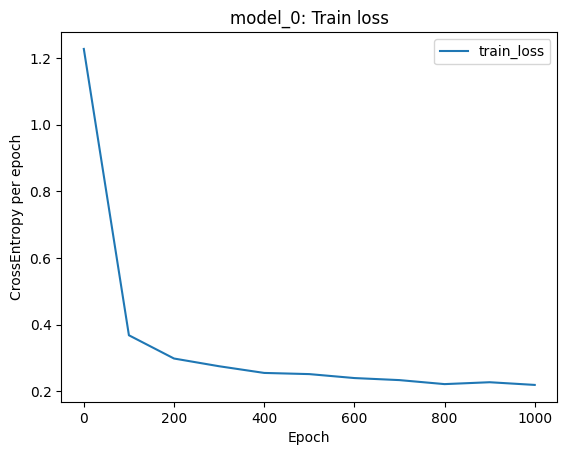

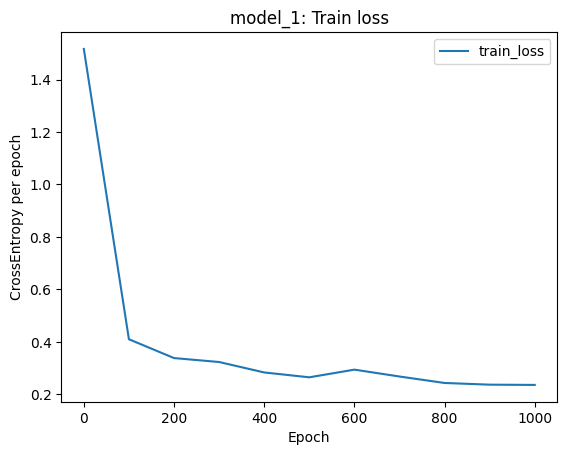

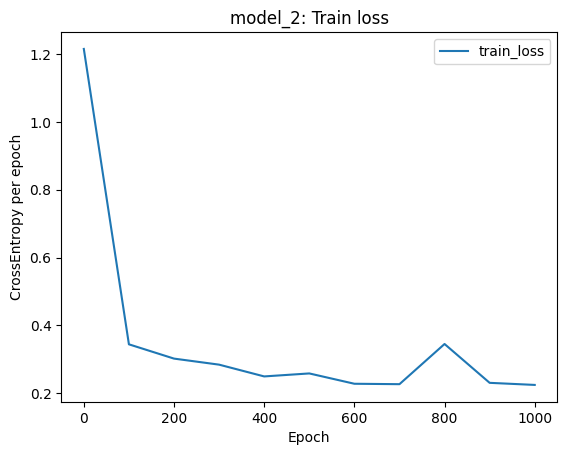

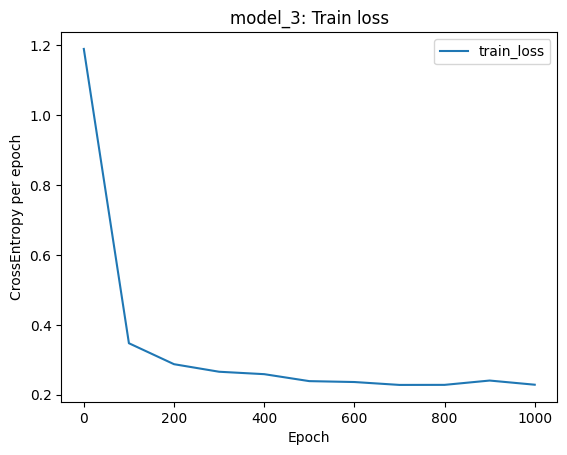

In [ ]:
for i in range(len(models)):
  plot_loss(loss_history=losses[i],
              epochs= 1000,
              model =  f"model_{i}")

## test

In [ ]:
accurancies = []
preds = []

for model in models:
  test_acc, y_test= test(data = data, model = model)
  accurancies.append(test_acc)
  preds.append(y_test)


Test Accuracy: 0.8550
Test Accuracy: 0.8795
Test Accuracy: 0.8931
Test Accuracy: 0.8629


Model_0 accieved accuracy of: 0.8550361918782972


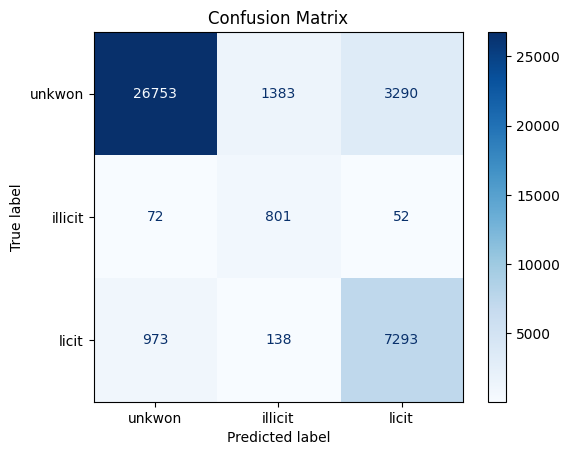

Model_1 accieved accuracy of: 0.8795485216537848


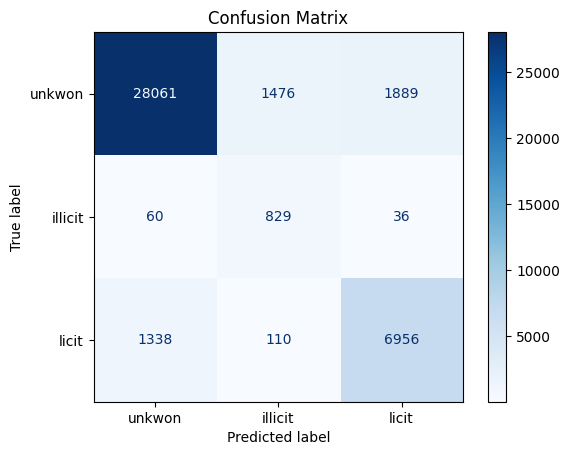

Model_2 accieved accuracy of: 0.8930683351735983


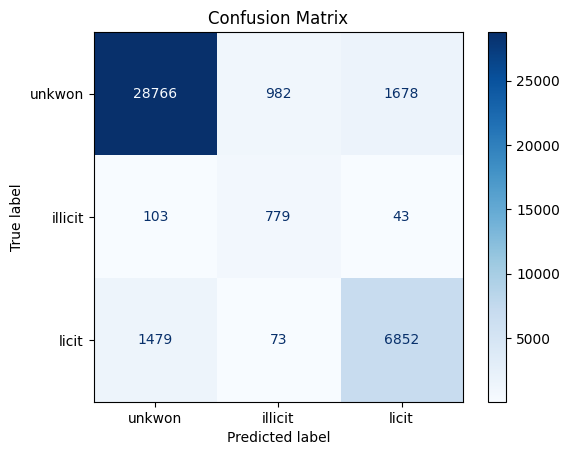

Model_3 accieved accuracy of: 0.8628634523371366


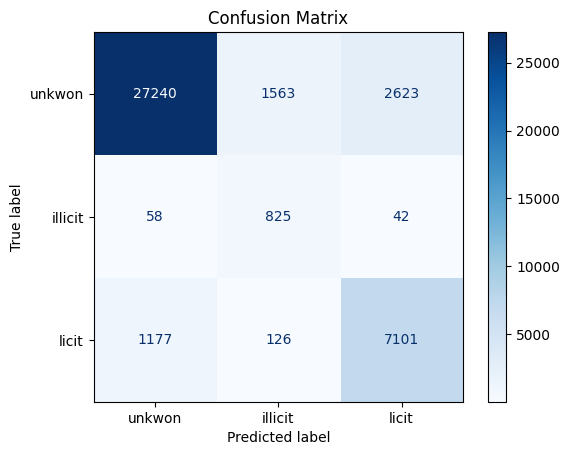

In [ ]:
for i in range(len(models)):
  print(f"Model_{i+1} accieved accuracy of: {accurancies[i]}")
  plot_acc(data, labels = preds[i])

## Visualize Embeddings

In [ ]:
embeddings_res = []
WS_residuals = []

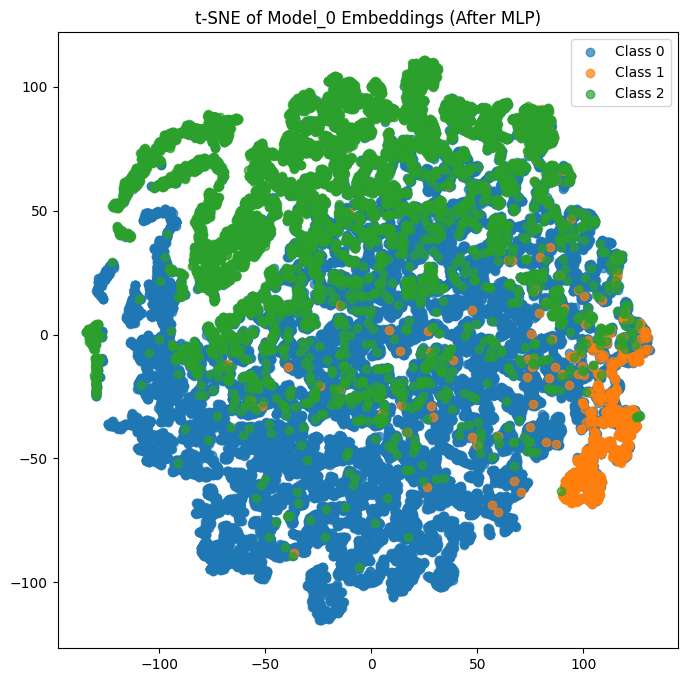

wasserstein distance Matrix for model_res_1 :
[[0.         0.55323455 0.47970719]
 [0.55323455 0.         1.        ]
 [0.47970719 1.         0.        ]]


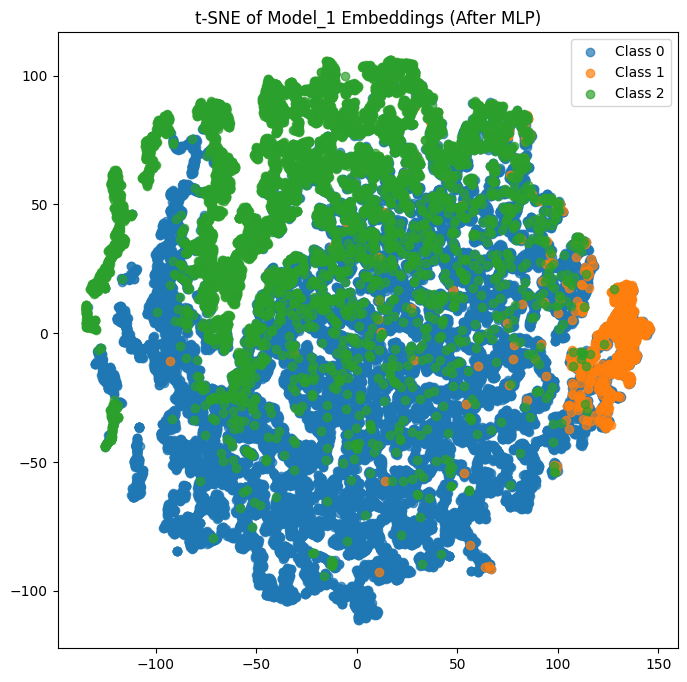

wasserstein distance Matrix for model_res_2 :
[[0.         0.68046147 0.52774752]
 [0.68046147 0.         1.        ]
 [0.52774752 1.         0.        ]]


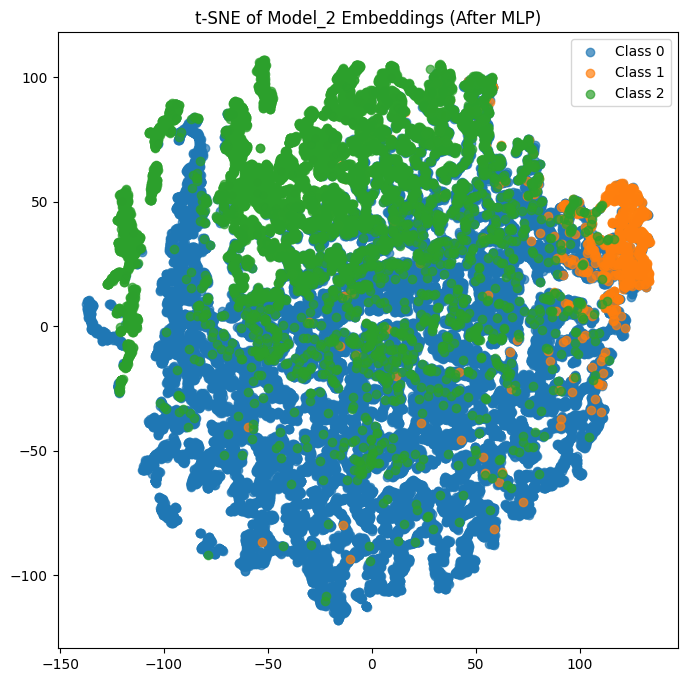

wasserstein distance Matrix for model_res_3 :
[[0.         0.99389094 0.65161417]
 [0.99389094 0.         1.        ]
 [0.65161417 1.         0.        ]]


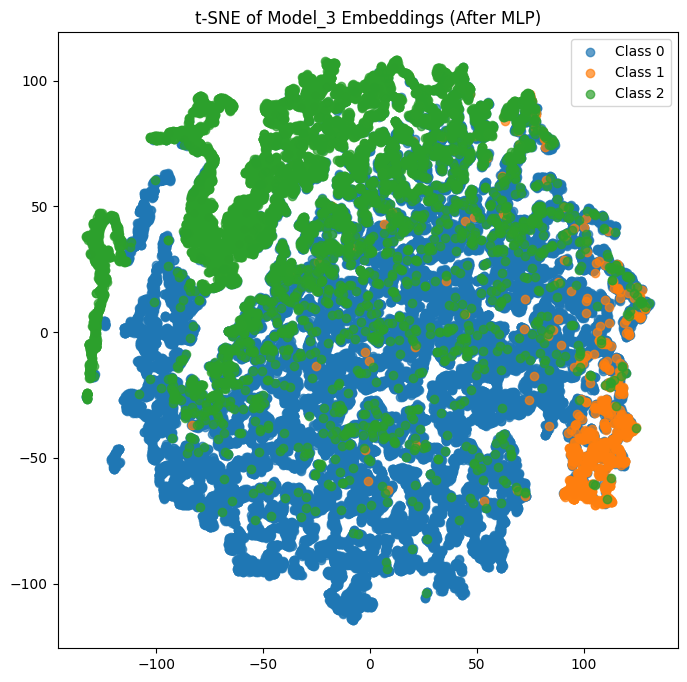

wasserstein distance Matrix for model_res_4 :
[[0.         0.54355261 0.48675945]
 [0.54355261 0.         1.        ]
 [0.48675945 1.         0.        ]]


In [ ]:


for model in models:
  model.eval()
  with torch.no_grad():
    test_embeddings_i = model.forward(data)[data.test_mask].cpu().numpy()
  embeddings_res.append(test_embeddings_i)

for i in range(len(embeddings_res)):
  WS_res=plot_tsne(embeddings_res[i], data.y[data.test_mask].cpu().numpy(), f't-SNE of Model_{i} Embeddings (After MLP)')
  print(f"wasserstein distance Matrix for model_res_{i+1} :\n{WS_res/np.max(WS_res)}")
  WS_residuals.append(WS_res)

In [ ]:
ws_mean_res = []

for i, w in enumerate(WS_residuals):
  ws_mean = w.mean()
  ws_mean_res.append(ws_mean)
  print(f"WS mean for model_{i+1}: {ws_mean}")


WS mean for model_1: 48.91642124742558
WS mean for model_2: 49.32732022006807
WS mean for model_3: 46.69286836912555
WS mean for model_4: 49.97249447363137


In [ ]:
ws_res_metrix = []

for i, emb in enumerate(embeddings_res):
  emb_metric = evaluate_embeddings(embeddings_res[i], data.y[data.test_mask].cpu().numpy())
  ws_res_metrix.append(emb_metric)
  print(f"WS mean for model_{i+1}: {emb_metric}")

WS mean for model_1: {'silhouette': 0.06447275, 'knn_accuracy': 0.8971414550361917}
WS mean for model_2: {'silhouette': 0.023623293, 'knn_accuracy': 0.8987363513679302}
WS mean for model_3: {'silhouette': 0.061924785, 'knn_accuracy': 0.8993006993006993}
WS mean for model_4: {'silhouette': 0.06851133, 'knn_accuracy': 0.8953748006379586}


# GAT

In [ ]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, BatchNorm




class MyGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_channels, n_heads, num_classes,dropout, self_loops= False):
        super(MyGAT, self).__init__()
        self.dropout = dropout
        self.out_head = hidden_channels

        self.conv1 = GATConv(input_features, hidden_channels, heads=n_heads, dropout = dropout, add_self_loops = self_loops)
        self.conv2 = GATConv(hidden_channels * n_heads, hidden_channels, heads=n_heads, dropout = dropout, add_self_loops = self_loops, concat=False)
        self.mlp = MyMPL2(hidden_channels, self.out_head, num_classes)



    def forward(self, data, before = False):
      x, edge_index = data.x, data.edge_index
      #x = F.dropout(x, p=self.dropout , training=self.training)
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)

      if before:
          return x

        # MPL layer


        # Output layer
      x = self.mlp(x)


      return x





In [ ]:
model_6 = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 3, dropout= 0.5).to(device)
model_6_sl = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 3, dropout= 0.5, self_loops= True).to(device)
print(model_6)
print(model_6_sl)


MyGAT(
  (conv1): GATConv(166, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)
MyGAT(
  (conv1): GATConv(166, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


## Train

In [ ]:
models = [model_6, model_6_sl]
seed = 42
set_seed(seed)

losses = []

for model in models:
  loss = train(epoch=1001,
      data=data,
      model = model,
      lr = .01,
      wd = 5e-4)
  losses.append(loss)


  0%|          | 2/1001 [00:00<03:36,  4.61it/s]

The current loss is 1.1048


 10%|█         | 102/1001 [00:28<03:58,  3.76it/s]

The current loss is 0.8959


 20%|██        | 202/1001 [00:56<03:41,  3.61it/s]

The current loss is 0.8901


 30%|███       | 302/1001 [01:25<03:13,  3.62it/s]

The current loss is 0.8857


 40%|████      | 402/1001 [01:55<02:47,  3.58it/s]

The current loss is 0.8847


 50%|█████     | 502/1001 [02:24<02:19,  3.57it/s]

The current loss is 0.8856


 60%|██████    | 602/1001 [02:53<01:50,  3.61it/s]

The current loss is 0.8914


 70%|███████   | 702/1001 [03:23<01:23,  3.59it/s]

The current loss is 0.8806


 80%|████████  | 802/1001 [03:52<00:55,  3.61it/s]

The current loss is 0.8871


 90%|█████████ | 902/1001 [04:21<00:27,  3.61it/s]

The current loss is 0.8830


100%|██████████| 1001/1001 [04:50<00:00,  3.44it/s]


The current loss is 0.8869


  0%|          | 2/1001 [00:00<04:01,  4.14it/s]

The current loss is 1.1322


 10%|█         | 102/1001 [00:37<05:18,  2.82it/s]

The current loss is 0.5266


 20%|██        | 202/1001 [01:15<04:41,  2.84it/s]

The current loss is 0.5012


 30%|███       | 302/1001 [01:52<04:06,  2.84it/s]

The current loss is 0.4927


 40%|████      | 402/1001 [02:29<03:32,  2.81it/s]

The current loss is 0.4776


 50%|█████     | 502/1001 [03:07<02:56,  2.83it/s]

The current loss is 0.5165


 60%|██████    | 602/1001 [03:44<02:20,  2.83it/s]

The current loss is 0.4792


 70%|███████   | 702/1001 [04:21<01:45,  2.83it/s]

The current loss is 0.4741


 80%|████████  | 802/1001 [04:58<01:10,  2.83it/s]

The current loss is 0.4790


 90%|█████████ | 902/1001 [05:36<00:35,  2.82it/s]

The current loss is 0.4829


100%|██████████| 1001/1001 [06:13<00:00,  2.68it/s]

The current loss is 0.4844


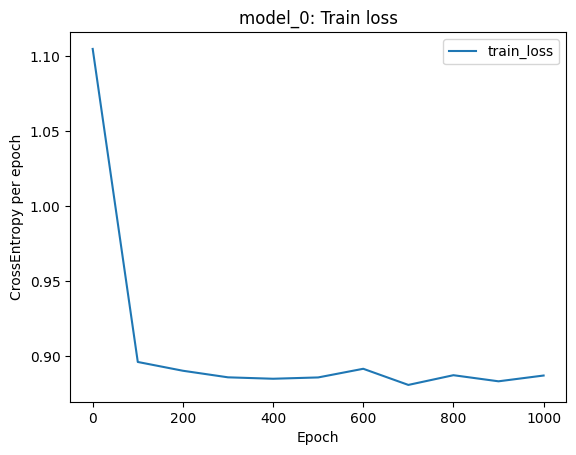

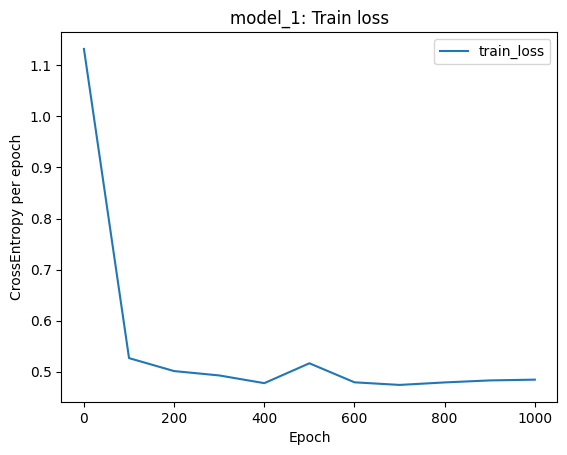

In [ ]:
for i in range(len(models)):
  plot_loss(loss_history=losses[i],
              epochs= 1000,
              model =  f"model_{i}")

## Test

In [ ]:
accurancies = []
preds = []

for model in models:
  test_acc, y_test= test(data = data, model = model)
  accurancies.append(test_acc)
  preds.append(y_test)


Test Accuracy: 0.4359
Test Accuracy: 0.7873


Model_0 accieved accuracy of: 0.4358974358974359


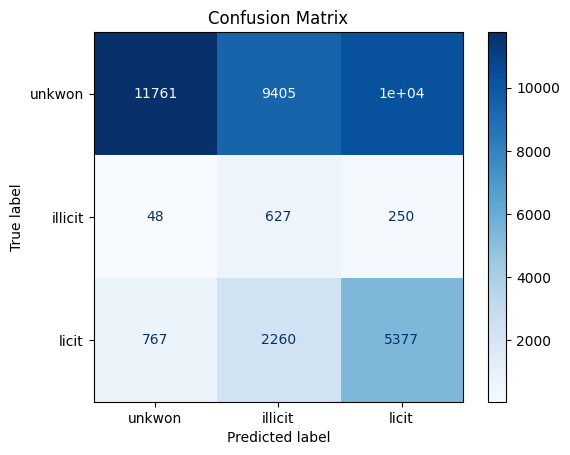

Model_1 accieved accuracy of: 0.7873144399460189


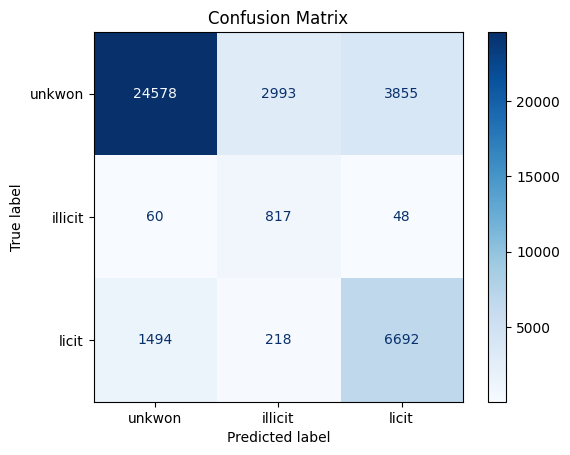

In [ ]:
for i in range(len(models)):
  print(f"Model_{i} accieved accuracy of: {accurancies[i]}")
  plot_acc(data, labels = preds[i])

## Visualize Embeddings

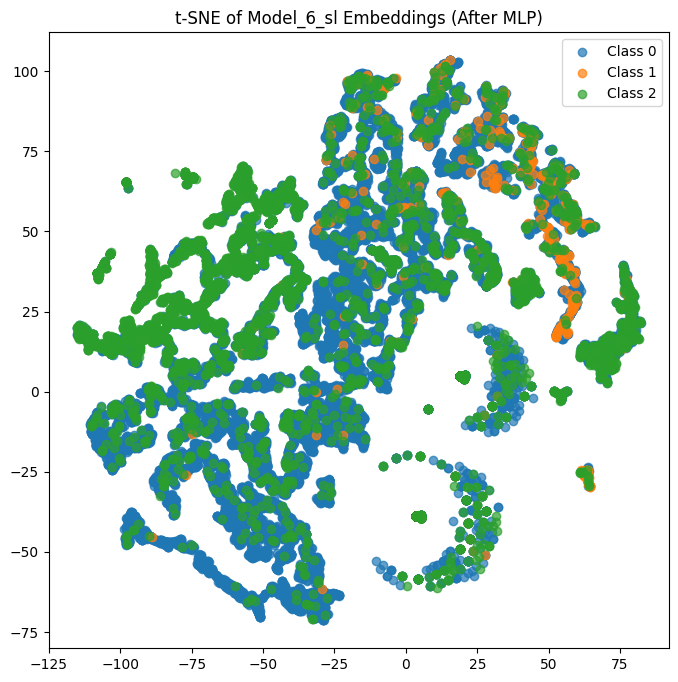

wasserstein distance Matrix:
[[0.         0.94631033 0.27610956]
 [0.94631033 0.         1.        ]
 [0.27610956 1.         0.        ]]


In [ ]:
model_6.eval()

with torch.no_grad():
  test_embeddings_6 = model_6.forward(data)[data.test_mask].cpu().numpy()

WS_Gat = plot_tsne(test_embeddings_6, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_Gat/np.max(WS_Gat)}")

In [ ]:
WS_mean_Gat= WS_Gat.mean()

In [ ]:
metrics_6 = evaluate_embeddings(test_embeddings_6, data.y[data.test_mask].cpu().numpy())
metrics_6

{'silhouette': -0.1329657, 'knn_accuracy': 0.7342902711323764}

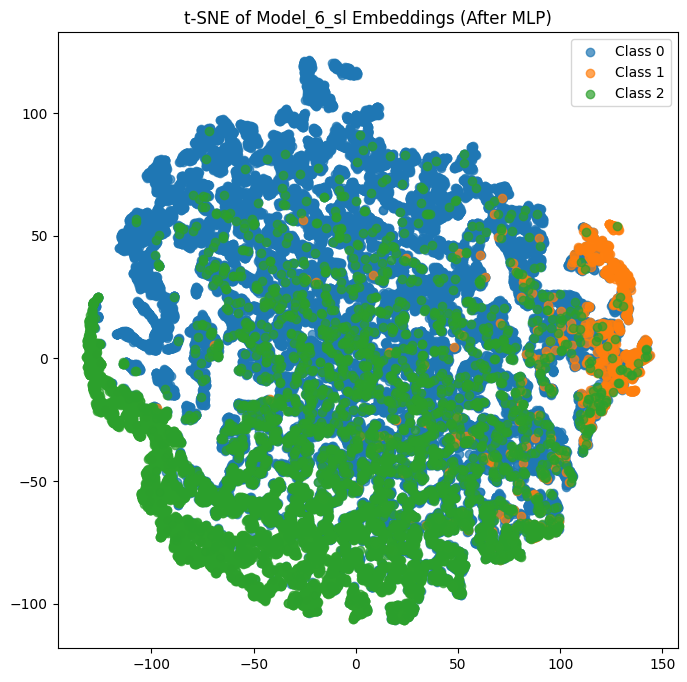

wasserstein distance Matrix:
[[0.         0.58689806 0.49296019]
 [0.58689806 0.         1.        ]
 [0.49296019 1.         0.        ]]


In [ ]:
model_6_sl.eval()

with torch.no_grad():
  test_embeddings_6_sl = model_6_sl.forward(data)[data.test_mask].cpu().numpy()

WS_Gat_sl = plot_tsne(test_embeddings_6_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_Gat_sl/np.max(WS_Gat_sl)}")

In [ ]:
WS_mean_Gat_sl = WS_Gat_sl.mean()

In [ ]:
metrics_6_sl = evaluate_embeddings(test_embeddings_6_sl, data.y[data.test_mask].cpu().numpy())
metrics_6_sl

{'silhouette': 0.14549139, 'knn_accuracy': 0.8632069684701262}

# MultiLayer GAT

In [ ]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, BatchNorm



class DeepGAT(torch.nn.Module):
    def __init__(self, in_channels, out, n_heads, n_layers, concat, num_classes, dropout):
        super(DeepGAT, self).__init__()

        self.n_layers = n_layers
        self.dropout = dropout

        # Calculate input sizes for each layer
        self.gat_layers = torch.nn.ModuleList(
            [GATConv(
            in_channels= in_channels if i == 0 else out*n_heads[i],
            out_channels= out ,
            heads=n_heads[i],
            dropout=dropout,
            concat=concat[i],
            add_self_loops = True
        )
             for i in range(n_layers)]
        )


        # Layer normalization
        self.layer_norm = torch.nn.ModuleList([
            torch.nn.LayerNorm(out * n_heads[i] if concat[i] else out)
            for i in range(n_layers)
        ])

        self.out_channels = [out * n_heads[i] if concat[i] else out for i in range(n_layers)]

         # Residual connection projection (if needed)
        self.residual_proj = torch.nn.ModuleList(
            [
              torch.nn.Linear(in_channels if i == 0 else (out * n_heads[i - 1] if concat[i - 1] else out),
                              self.out_channels[i])
    for i in range(n_layers)
])




        self.ff = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(out * n_heads[i] if concat[i] else out, out),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout),
                torch.nn.Linear(out, out * n_heads[i] if concat[i] else out)
            )
            for i in range(n_layers)
        ])


        # Final classification layer
        self.classifier = torch.nn.Linear(out, num_classes)

    def forward(self, data, ret = False):
      x, edge_index = data.x, data.edge_index

      for i in range(self.n_layers):
          #print(i)
          # Residual connection
          res = x
          if (i ==0) or (i == self.n_layers-1):
              res = self.residual_proj[i](res)
         # print(res.shape)

          x = self.gat_layers[i](x, edge_index)
          #print(x.shape)
          x = self.layer_norm[i](x+res)

          #print(x.shape)
          x = x + self.ff[i](x)
          #x = self.ff[i](x)  # Apply the feed-forward layer

      if ret:
        print(x.shape)
        return x
      # Final classification
      x = self.classifier(x)

      return x



In [ ]:
model_7 = DeepGAT(in_channels = data.num_features,
                  out = 64,
                  n_heads = [8,8,8],
                  n_layers=3,
                  concat= [True, True, False],
                  num_classes = 3,
                  dropout=0.5).to(device)

## Train

In [ ]:
seed = 42
set_seed(seed)

losses = []

loss_p = train(epoch=1001,
      data=data,
      model = model_7,
      lr = .01,
      wd = 5e-4)


  0%|          | 1/1001 [00:00<12:18,  1.35it/s]

The current loss is 1.2009


 10%|█         | 101/1001 [01:10<12:12,  1.23it/s]

The current loss is 0.5277


 20%|██        | 201/1001 [02:19<10:55,  1.22it/s]

The current loss is 0.4421


 30%|███       | 301/1001 [03:29<09:33,  1.22it/s]

The current loss is 0.4123


 40%|████      | 401/1001 [04:38<08:11,  1.22it/s]

The current loss is 0.3914


 50%|█████     | 501/1001 [05:47<06:49,  1.22it/s]

The current loss is 0.5017


 60%|██████    | 601/1001 [06:57<05:27,  1.22it/s]

The current loss is 0.3676


 70%|███████   | 701/1001 [08:06<04:06,  1.22it/s]

The current loss is 0.3407


 80%|████████  | 801/1001 [09:15<02:43,  1.22it/s]

The current loss is 0.4395


 90%|█████████ | 901/1001 [10:25<01:21,  1.22it/s]

The current loss is 0.3553


100%|██████████| 1001/1001 [11:34<00:00,  1.44it/s]

The current loss is 0.3552


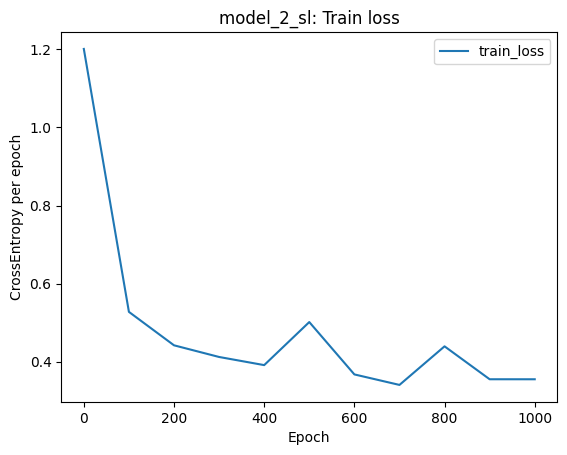

In [ ]:
plot_loss(loss_history=loss_p,
              epochs= 1000,
              model =  "model_2_sl")

## Test

In [ ]:
test_acc_p, y_test_p= test(data = data, model = model_7)

Test Accuracy: 0.8421


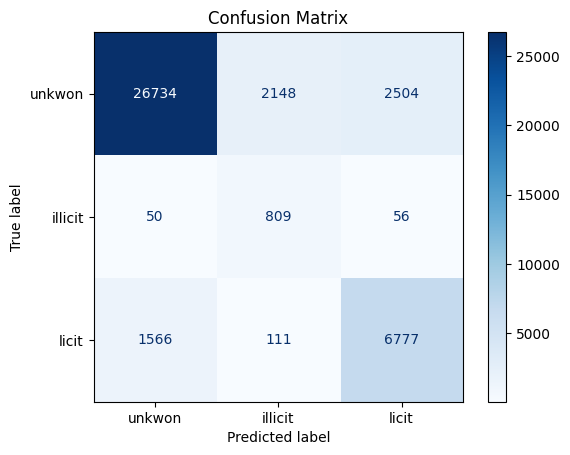

In [ ]:
plot_acc(data, y_test_p)


## Visualize Embeddings

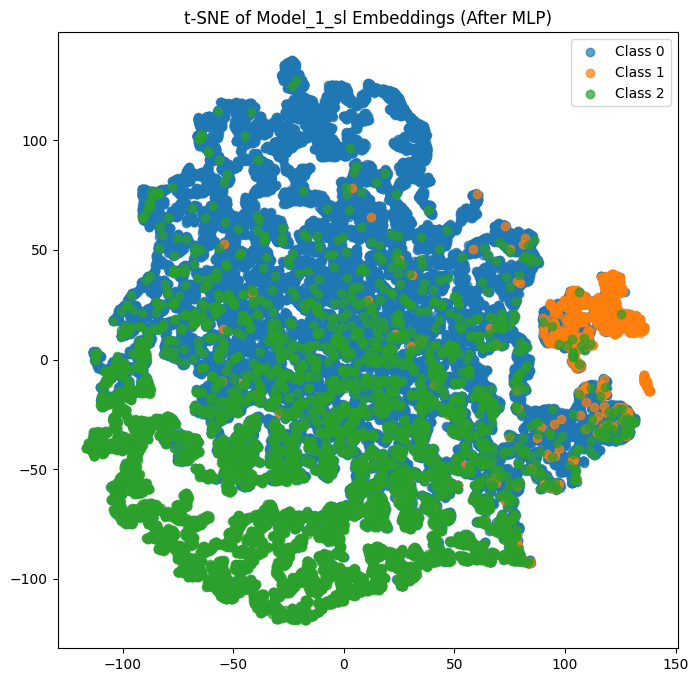

wasserstein distance Matrix:
[[  0.          63.98546124  56.91284803]
 [ 63.98546124   0.         103.57282943]
 [ 56.91284803 103.57282943   0.        ]]


In [ ]:
model_7.eval()

with torch.no_grad():
  test_embeddings_7 = model_7.forward(data)[data.test_mask].cpu().numpy()

WS_DeepGat = plot_tsne(test_embeddings_7, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_1_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_DeepGat/np.max(WS_DeepGat)}")

In [ ]:
WS_mean_DeepGat= WS_DeepGat.mean()

In [ ]:
metrics = evaluate_embeddings(test_embeddings_7, data.y[data.test_mask].cpu().numpy())
metrics

{'silhouette': 0.27846748, 'knn_accuracy': 0.8853392221813274}

# Compare every models' embeddings and choose the best one

In [ ]:
# Define mean_ws by combining the initial values with those from ws_mean_res
mean_ws = [WS_mean_DeepGat, WS_mean_Gat, WS_mean_Gat_sl, WS_mean_GNN1, WS_mean_GNN2, WS_mean_GNN1_sl, WS_mean_GNN2_sl]
mean_ws.extend(ws_mean_res)  # Use extend instead of append for adding elements from a list

# Define metrics_ls by combining the initial values with those from ws_res_metrix
metrics_ls = [metrics, metrics_6, metrics_6_sl, metrics_1, metrics_2, metrics_1_sl, metrics_2_sl]
metrics_ls.extend(ws_res_metrix)  # Use extend instead of append for adding elements from a list

# Initialize empty lists for silhouette and knn_accuracy
silhouette_ls = []
knn_accuracy_ls = []

# Extract silhouette and knn_accuracy values from metrics_ls
for d in metrics_ls:
    for k, v in d.items():
        if k == "silhouette":
            silhouette_ls.append(v)
        else:
            knn_accuracy_ls.append(v)

# Define the model names
models_ls = ["model_7", "model_6", "model_6_sl", "model_1", "model_2", "model_1_sl", "model_2_sl","model_4", "model_4_sl", "model_5", "model_5_sl" ]

# Create the evaluation dictionary
eval_dict = {
    "mean_ws": mean_ws,
    "silhouette": silhouette_ls,
    "knn_accuracy": knn_accuracy_ls
}

eval_df = pd.DataFrame(eval_dict, index = models_ls)
eval_df

mean_ws  silhouette  knn_accuracy
model_7     49.882475    0.278467      0.885339
model_6     11.216800   -0.132966      0.734290
model_6_sl  47.593750    0.145491      0.863207
model_1     11.172521   -0.346396      0.623727
model_2      9.061824   -0.405472      0.652214
model_1_sl  45.679086    0.071369      0.855821
model_2_sl  44.620579    0.089752      0.837002
model_4     48.916421    0.064473      0.897141
model_4_sl  49.327320    0.023623      0.898736
model_5     46.692868    0.061925      0.899301
model_5_sl  49.972494    0.068511      0.895375

In [ ]:
eval_df.to_csv('eval_results_tot.csv', index=True)

# GraphSMOTE

In [ ]:
from scipy.spatial.distance import pdist,squareform
from copy import deepcopy
import random
from torch_geometric.utils import to_dense_adj


im_class_num=1
def src_smote(adj, features, labels, idx_train, portion=1.0, im_class_num=1):
    c_largest = labels.max().item()
    # Select nodes belonging to minority classes
    new_chosen = idx_train[(labels == 1)]

    # Portion Calculation
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    if portion == 0:
        c_portion = int(avg_number/new_chosen.shape[0])
        portion_rest = (avg_number/new_chosen.shape[0]) - c_portion
    else:
        c_portion = int(portion)
        portion_rest = portion - c_portion

    chosen = None
    new_features = None

    for j in range(c_portion):
        new_chosen = torch.tensor(new_chosen)
        chosen_embed = emb[(labels == 1)]

        distance = squareform(pdist(chosen_embed.cpu().detach()))
        np.fill_diagonal(distance, distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)

        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:] - chosen_embed) * interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed), 0)

    if portion_rest > 0:
        num = int(new_chosen.shape[0] * portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:][(labels == 1)]
        distance = squareform(pdist(chosen_embed.cpu().detach()))
        np.fill_diagonal(distance, distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)

        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:] - chosen_embed) * interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed), 0)

    # Handling edge index creation
    row, col = adj.indices()
    num_orig_nodes = features.shape[0]
    num_new_nodes = chosen.shape[0]

    # New edges connecting synthetic nodes to original nodes
    new_row_1 = torch.cat([row, chosen.repeat(num_orig_nodes)])
    new_col_1 = torch.cat([col, torch.repeat_interleave(torch.arange(num_orig_nodes), num_new_nodes)])

    # Edges between synthetic nodes
    if num_new_nodes > 1:
        synthetic_row = torch.repeat_interleave(chosen, num_new_nodes)
        synthetic_col = chosen.repeat(num_new_nodes)

        new_row = torch.cat([new_row_1, synthetic_row])
        new_col = torch.cat([new_col_1, synthetic_col])
    else:
        new_row = new_row_1
        new_col = new_col_1

    # Create new sparse adjacency matrix
    new_edge_index = torch.stack([new_row, new_col])

    # Update features and labels
    features_append = deepcopy(new_features)
    labels_append = torch.ones(new_features.shape[0], dtype=torch.as_tensor(labels).dtype)

    idx_new = torch.arange(num_orig_nodes, num_orig_nodes + num_new_nodes)

    features = torch.cat((features, features_append), 0)
    labels = torch.from_numpy(labels)
    labels = torch.cat((labels, labels_append), 0)
    idx_train = torch.from_numpy(idx_train)

    idx_train = torch.cat((idx_train, idx_new), 0)

    # Create new sparse tensor instead of using sparse_coo_tensor
    new_adj = torch.sparse_csr_tensor(
        new_edge_index[0],
        new_edge_index[1],
        torch.ones(new_edge_index.shape[1]),
        size=(num_orig_nodes + num_new_nodes, num_orig_nodes + num_new_nodes)
    )

    return new_adj, features, labels, idx_train, features_append


In [ ]:
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import k_hop_subgraph


model_7.eval()
data.to("cuda")
with torch.no_grad():
  emb = model_7.forward(data)[data.train_mask].to("cpu")

data.to("cpu")

idx_train = torch.where(data.train_mask)[0].numpy()
labels = data.y[data.train_mask].numpy()
features = emb
#features = emb[(labels == 1)]
#adj = to_dense_adj(edge_index)
adj = data.edge_index.to_sparse_coo()

print(f"emb shape: {emb.shape}")
print(f"labels shape: {labels.shape}")
print(f"adj shape: {data.edge_index.shape}")
print(f"feature shape: {features.shape}")

print(type(labels))

emb shape: torch.Size([122261, 3])
labels shape: (122261,)
adj shape: torch.Size([2, 234355])
feature shape: torch.Size([122261, 3])
<class 'numpy.ndarray'>


In [ ]:
adj.indices()

tensor([[     0,      0,      0,  ...,      1,      1,      1],
        [     1,      2,      3,  ..., 234352, 234353, 234354]])

In [ ]:
adj_1, features_1, labels_1, idx_train_1, t  = src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=1)

In [ ]:
data.x = features_1
data.edge_index = adj_1
data.y = labels_1
data.train_mask = idx_train_1

In [ ]:
data.edge_index.shape

torch.Size([124977, 124977])

In [ ]:
features_1.shape

torch.Size([124977, 3])

In [ ]:
data.y.shape

torch.Size([124977])

In [ ]:
data.train_mask.shape

torch.Size([124977])

In [ ]:
data.y[data.train_mask] == 1

#filtered_labels = data.y[data.train_mask][labels_subset]
#f = features_1[labels_subset]
#print(f.shape)
#WS_DeepGat = plot_tsne(features_1, filtered_labels.cpu().numpy(), 't-SNE of Model_1_sl Embeddings (After MLP)')
#print(f"wasserstein distance Matrix:\n{WS_DeepGat/np.max(WS_DeepGat)}")

IndexError: index 156405 is out of bounds for dimension 0 with size 124977